In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import json

In [2]:
f = open('data.json', encoding="utf8")
data = json.load(f)
for d in data:
    d['text'] = d['title'] + d['text']
df = pd.DataFrame(data)
del df['website']
del df['title']
df.head()

,labels,text
0,[Coronavirus],Coronavirus: Royal Mail's Derry staff in stand...
1,"[US election 2020, Donald Trump]",US election 2020 polls: Who is ahead - Trump o...
2,"[Personal finance, Companies, Retailing, Coron...",Visa and Mastercard accused of charging 'exces...
3,[United States],Jeff Bridges: Oscar-winning US actor reveals h...
4,"[Boris Johnson, Brexit]",Brexit: Have EU-UK trade talks reached a dead ...


In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])
number_of_classes = y.shape[1]
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [5]:
X = []
sentences = list(df["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [6]:
tags = {}
for t in mlb.classes_:
    tags[t] = 0
for l in df['labels']:
    for t in l:
        tags[t] += 1

for t in tags:
    tags[t] = (int)(tags[t]*0.2)

val_tags = tags.copy()

In [7]:
X_train = []
X_test = []
X_val = []

y_train = np.empty(shape=(0,len(mlb.classes_)),dtype=int)
y_test = np.empty(shape=(0,len(mlb.classes_)),dtype=int)
y_val = np.empty(shape=(0,len(mlb.classes_)),dtype=int)

for x in range(len(X)):
    flag = 0
    for t in df.iloc[x]['labels']:
        if(tags[t] > 0):
            flag = 1
            break;
        elif(val_tags[t] > 0):
            flag = 2
            break;
        
    if flag == 1:
        for t in df.iloc[x]['labels']:
            tags[t] -= 1
        X_test.append(df.iloc[x]['text'])
        y_test = np.vstack([y_test, y[x]])
    elif flag == 2:
        for t in df.iloc[x]['labels']:
            val_tags[t] -= 1
        X_val.append(df.iloc[x]['text'])
        y_val = np.vstack([y_val, y[x]])
    else:
        X_train.append(df.iloc[x]['text'])
        y_train = np.vstack([y_train, y[x]])

In [8]:
sum_y = y.sum(axis = 0)
class_weight = {}
for x in range(number_of_classes):
    class_weight[x] = (1 / sum_y[x])*(len(data))/number_of_classes

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_length = 512 # can be up to 512 for BERT
batch_size = 6

In [10]:
def convert_example_to_feature(text):
  return tokenizer.encode_plus(text, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation=True,
              )

# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(text_list, labels):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for t in text_list:
    bert_input = convert_example_to_feature(t)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, labels)).map(map_example_to_dict)

In [15]:
ds_train_encoded = encode_examples(X_train, y_train).batch(batch_size)
ds_test_encoded = encode_examples(X_test, y_test).batch(batch_size)
ds_val_encoded = encode_examples(X_val, y_val).batch(batch_size)

In [12]:
from transformers import TFBertForSequenceClassification

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=number_of_classes) # conda install -c anaconda h5py==2.10

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
number_of_epochs = 5
history = model.fit(ds_train_encoded,
                    epochs=number_of_epochs,
                    validation_data=ds_val_encoded,
                    class_weight=class_weight
                    )

Train for 372 steps, validate for 130 steps
Epoch 1/5
372/372 [==============================] - 5717s 15s/step - loss: 0.3871 - acc: 0.9186 - val_loss: 0.3300 - val_acc: 0.9393
Epoch 2/5
372/372 [==============================] - 5662s 15s/step - loss: 0.2352 - acc: 0.9192 - val_loss: 0.1985 - val_acc: 0.8907
Epoch 3/5
372/372 [==============================] - 5577s 15s/step - loss: 0.1696 - acc: 0.9293 - val_loss: 0.1623 - val_acc: 0.9208
Epoch 4/5
372/372 [==============================] - 5672s 15s/step - loss: 0.0998 - acc: 0.9410 - val_loss: 0.1042 - val_acc: 0.9431
Epoch 5/5
372/372 [==============================] - 5515s 15s/step - loss: 0.0829 - acc: 0.9504 - val_loss: 0.0967 - val_acc: 0.9543


In [17]:
score = model.evaluate(ds_test_encoded, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

122/122 [==============================] - 488s 4s/step - loss: 0.2033 - acc: 0.9566
Test Score: 0.20333769996116152
Test Accuracy: 0.9565842


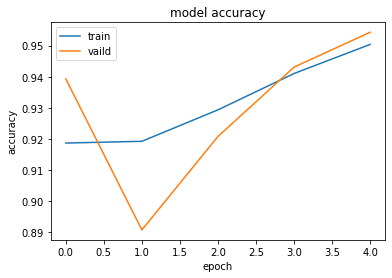

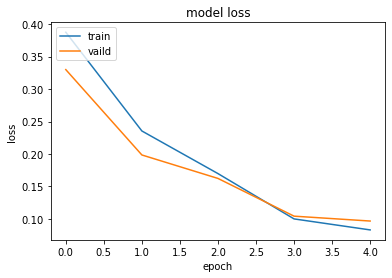

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.savefig("bert_acc.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.savefig("bert_loss.png")
plt.show()